# Policy gradient methods
As an alternative to Deep Q-Learning (DQN) where the policy is implicit, we can train a (deep) neural network to
output the _probability distribution_ over the actions given a state as an input
(**policy network**). Hence, we can directly sample an action from the policy, without
the need for an epsilon-greedy strategy. This class of algorithms is called **policy
gradient methods** and there are many different types of these.

In a _stochastic policy gradient_ method the output of the neural network is an _action vector_ that represents
a probability distribution. This allows the agent to explore enough, before the action
distribution converges to producing the single best action (degenerate probability
distribution), when the environment is stationary (constant distribution of
states and rewards).

The probability of an action, given the parameters $\theta$ of the policy network, is
denoted $\pi_s(a|\theta)$. When training the policy network, we want it to assign more probability to the winning
actions, based on a collection of episodes (sequences of states, actions and rewards
recorded while interacting with the environment). Our objective then is to maximize the
performance of the parameterized policy using **gradient ascent**. To do that, we define an objective function
$J(\theta)$, that is, the _expected cumulative reward_, and we want to find the set of
parameters $\theta$ that maximizes this objective function.

Advantages:
- Better convergence properties
- Eﬀective in high-dimensional or continuous action spaces
- Can learn stochastic policies
Disadvantages:
- Typically converge to a local rather than global optimum
- Evaluating a policy is typically inefficient and high variance

Advantages:
- aaaa..

Disadvantages:
- ....

<figure>
    <img src="policy_grad_loss.png" alt="Caption" width="800" />
    <figcaption>Policy gradient objective function (taken from huggingface.co).</figcaption>
</figure>

Here, $J(\theta)$ is the **expected cumulative return**, that we calculate by summing over all trajectories
  $\tau$, the probability $P(\tau;\theta)$ of taking that trajectory given $\theta$, multiplied by
  the _cumulative reward_ $R(\tau)$ of this trajectory, i.e.
  
$$ R(\tau) = \sum_{k=0}^{T-1} \gamma^k r_k $$

with $\gamma < 1$ the _discount factor_, and $T$ the number of time steps in the episode.

  Thanks to the **Policy Gradient Theorem**, we
  can estimate $\nabla J$ as:

  $$\nabla J(\theta) = \mathbb{E}_\pi[\nabla \log \pi_s(a|\theta)R(\tau)]$$

  A Monte-Carlo estimate of this gradient is given by:

<figure>
    <img src="policy_gradient_multiple.png" alt="Caption" width="800" />
    <figcaption>Policy gradient objective function (taken from huggingface.co).</figcaption>
</figure>

## The REINFORCE algorithm

<figure>
    <img src="reinforce_pseudocode.png" alt="Caption" width="800" />
    <figcaption>Pseudocode of the REINFORCE algorithm (taken from huggingface.co).</figcaption>
</figure>

When we calculate the return Gt (line 6), we see that we calculate the sum of discounted rewards starting at timestep t.

Why? Because our policy should only reinforce actions on the basis of the consequences: so rewards obtained before taking an action are useless (since they were not because of the action), only the ones that come after the action matters.

In [19]:
import numpy as np
from flax import nnx
import gymnasium as gym
from matplotlib import pyplot as plt
import optax
import jax

def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

env = gym.make("CartPole-v1")

In [111]:
import jax.numpy as jnp

def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    # A: Compute exponentially decaying rewards
    disc_return = jnp.power(gamma, jnp.arange(lenr)) * rewards
    # B: Normalize the rewards to be within the [0,1] interval for numerical stability
    disc_return /= disc_return.max()
    return disc_return

In [123]:
class PolicyNetwork(nnx.Module):
  def __init__(self, l1, l2, l3, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(l1, l2, rngs=rngs)
    self.linear2 = nnx.Linear(l2, l3, rngs=rngs)

  def __call__(self, x):
    y = nnx.leaky_relu(self.linear1(x))
    y = nnx.leaky_relu(self.linear2(y))
    y = nnx.softmax(y)
    return y

l1 = 4
l2 = 150
l3 = 2

learning_rate = 0.005
model = PolicyNetwork(l1, l2, l3, nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(learning_rate))

In [124]:
# Loss function for REINFORCE
@nnx.jit
def loss_fn(model, states, actions, discounted_rewards):
    log_probs = jnp.log(jnp.take_along_axis(model(states), actions[:, None], axis=1).squeeze())
    return -jnp.sum(log_probs * discounted_rewards)


# Training step
@nnx.jit
def train_step(model, optimizer, states, actions, discounted_rewards):
    loss, grads = nnx.value_and_grad(loss_fn)(model, states, actions, discounted_rewards)
    optimizer.update(grads)
    return loss

In [125]:
MAX_DUR = 200
MAX_EPISODES = 800
gamma = 0.99
score = [] #A
expectation = 0.0
for episode in range(MAX_EPISODES):
    curr_state = env.reset()[0]
    done = False
    states, actions = [], []

    num_t = MAX_DUR 
    
    for t in range(MAX_DUR):
        act_prob = model(curr_state)
        action = np.random.choice(np.array([0,1]), p=act_prob.__array__())

        next_state, _, terminated, truncated, info = env.step(action)

        # Record episode data
        states.append(curr_state)
        actions.append(action)

        curr_state = next_state

        if terminated or truncated:
            num_t = t + 1
            break

    ep_len = len(states) #I
    score.append(ep_len)
    cumul_rewards = jnp.arange(1, num_t + 1)

    # reverse array of cumulative rewards to get future rewards
    future_rewards = jnp.flip(cumul_rewards, axis=0)

    disc_future_rewards = discount_rewards(future_rewards)

    states = np.array(states)
    actions = np.array(actions)

    # Update policy parameters
    loss = train_step(model, optimizer, states, actions, disc_future_rewards) 
        
    # Logging for every episode
    if episode % 100 == 0:
        print(f"Episode {episode}, Loss: {loss}, Total Reward: {cumul_rewards[-1]}")

Episode 0, Loss: 5.045558452606201, Total Reward: 14
Episode 100, Loss: 19.386211395263672, Total Reward: 97
Episode 200, Loss: 11.101123809814453, Total Reward: 54
Episode 300, Loss: 19.244083404541016, Total Reward: 106
Episode 400, Loss: 25.980119705200195, Total Reward: 200
Episode 500, Loss: 24.994890213012695, Total Reward: 200
Episode 600, Loss: 22.324172973632812, Total Reward: 200
Episode 700, Loss: 21.472780227661133, Total Reward: 200


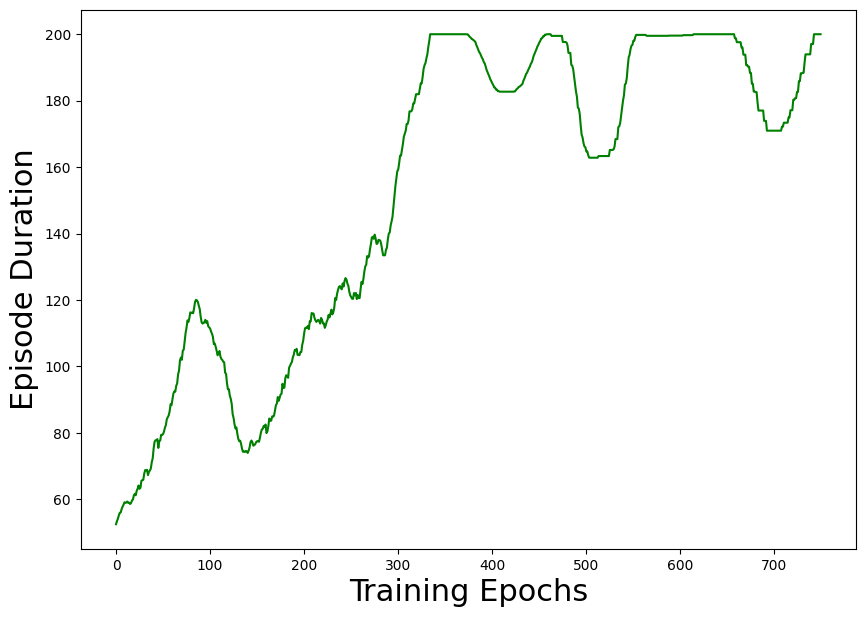

In [126]:
score = np.array(score)
avg_score = running_mean(score, 50)
plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')

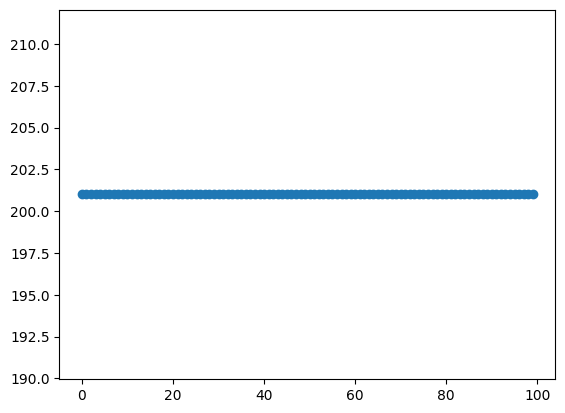

In [127]:
score = []
games = 100
done = False
state1 = env.reset()[0]
for i in range(games):
    t=0
    while True:
        if type(state1) is tuple:
            state1 = state1[0]
        pred = model(state1)
        action = np.random.choice(np.array([0,1]), p=pred.__array__())
        state2, reward, terminated, truncated, info = env.step(action)
        state1 = state2
        if(type(state1) == 'tuple'):
            state1 = state2[0]
        
        t += 1
        if t > MAX_DUR or truncated or terminated:
            break;
    state1 = env.reset()
    done = False
    score.append(t)

score = np.array(score)
plt.scatter(np.arange(score.shape[0]),score)
plt.show()